# Training and evaluating decoding models with PyTorch

This tutorial introduces a typical decoding framework for mapping brain activity onto stimulus features during natural language comprehension using PyTorch.

The previous tutorial walked through extracting two types of linguistic features: syntactic features and language model word embeddings. The podcast-ecog dataset comes with several other feature spaces as well. For this tutorial, we will use the LLM contextual embeddings. Decoding models map brain activity onto these features. Here, we use PyTorch to train deep learning decoding models.

Acknowledgments: This tutorial draws heavily on the encling tutorial by Samuel A. Nastase.

In [ ]:
# only run this cell in colab
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
!pip install mne mne_bids himalaya scikit-learn pandas matplotlib nilearn

In [64]:
import mne
import h5py
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

from nilearn.plotting import plot_markers
from mne_bids import BIDSPath

from himalaya.backend import set_backend, get_backend
from himalaya.scoring import correlation_score

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

We will set the Himalaya backend to torch_cuda so we can utilize a GPU for training, if available.

In [3]:
if torch.cuda.is_available():
    set_backend("torch_cuda")
    device = torch.device("cuda")
    print("Using cuda!")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CPU


## Loading features

We will now load two contextual word embeddings from GPT-2 (Radford et al., 2019). The loaded features should be a numpy array with a shape of (number of tokens * feature dimensions). Note that the numbers of tokens are different for the two features because of different tokenization schemas.

In [5]:
# bids_root = ""  # if using a local dataset, set this variable accordingly

# # Download the embedding, if required
# embedding_path = f"{bids_root}stimuli/gpt2-xl/features.hdf5"
# if not len(bids_root):
#     !wget -nc https://s3.amazonaws.com/openneuro.org/ds005574/$embedding_path
#     embedding_path = "features.hdf5"
embedding_path = "features.hdf5"

print(f"Using embedding file path: {embedding_path}")

Using embedding file path: features.hdf5


In [6]:
modelname, layer = 'gpt2-xl', 24
with h5py.File(embedding_path, "r") as f:
    contextual_embeddings = f[f"layer-{layer}"][...]
print(f"LLM embedding matrix has shape: {contextual_embeddings.shape}")

LLM embedding matrix has shape: (5491, 1600)


We will also load the stimuli transcripts associated with these features. Both transcripts should contain information about the word, token, start (onset), and end (offset). The contextual word embedding transcript should also include other prediction information extracted from GPT-2, like rank, probability, and entropy. For instance, we can calculate how accurate the model is in predicting the next token in the transcript based on the rank column, which are integers that represents the rank of the actual token in all the possible tokens of GPT-2.

Note: Check that the transcript contains the same number of tokens as the features we loaded before.

In [7]:
# Download the transcript, if required
transcript_path = f"{bids_root}stimuli/gpt2-xl/transcript.tsv"
if not len(bids_root):
    !wget -nc https://s3.amazonaws.com/openneuro.org/ds005574/$transcript_path
    transcript_path = "transcript.tsv"

# Load transcript
df_contextual = pd.read_csv(transcript_path, sep="\t", index_col=0)
if "rank" in df_contextual.columns:
    model_acc = (df_contextual["rank"] == 0).mean()
    print(f"Model accuracy: {model_acc*100:.3f}%")

df_contextual.head()

zsh:1: command not found: wget
Model accuracy: 30.942%


,word_idx,word,start,end,hftoken,token_id,rank,true_prob,top_pred,entropy
0,0,Act,3.710,3.790,ĠAct,2191,1644,0.000012,0,2.402717
1,1,"one,",3.990,4.190,Ġone,530,92,0.000342,352,3.732053
2,1,"one,",3.990,4.190,",",11,3,0.059520,25,4.259335
3,2,monkey,4.651,4.931,Ġmonkey,21657,4022,0.000018,3715,6.621269
4,3,in,4.951,5.011,Ġin,287,15,0.004237,0,4.444838


When we extracted features, some words are split into separate tokens. Since we only have information of start and end for words, we will align the features from tokens to words for decoding models. Here, we simply average the token features across the same word. Now the features should be a numpy array with a shape of (number of words * feature dimensions).

In [8]:
aligned_embeddings = []
for _, group in df_contextual.groupby("word_idx"): # group by word index
    indices = group.index.to_numpy()
    average_emb = contextual_embeddings[indices].mean(0) # average features
    aligned_embeddings.append(average_emb)
aligned_embeddings = np.stack(aligned_embeddings)
print(f"LLM embeddings matrix has shape: {aligned_embeddings.shape}")

LLM embeddings matrix has shape: (5136, 1600)


We will also construct a dataframe containing words with their start and end timestamps.

In [9]:
df_word = df_contextual.groupby("word_idx").agg(dict(word="first", start="first", end="last"))
df_word.head()

,word,start,end
word_idx,,,
0,Act,3.710,3.790
1,"one,",3.990,4.190
2,monkey,4.651,4.931
3,in,4.951,5.011
4,the,5.051,5.111


## Loading brain data

Next, we will load the preprocessed high-gamma ECoG data using MNE. Here, we will demonstrate loading data from our third subject.

In [99]:
file_path = BIDSPath(root=f"{bids_root}derivatives/ecogprep",
                    subject="03", task="podcast", datatype="ieeg", description="highgamma",
                    suffix="ieeg", extension=".fif")
print(f"File path within the dataset: {file_path}")

# You only need to run this if using Colab (i.e. if you did not set bids_root to a local directory)
if not len(bids_root):
    !wget -nc https://s3.amazonaws.com/openneuro.org/ds005574/$file_path
    file_path = file_path.basename

raw = mne.io.read_raw_fif(file_path, verbose=False)
picks = mne.pick_channels_regexp(raw.ch_names, "LG[AB]*")
raw = raw.pick(picks)
raw

File path within the dataset: derivatives/ecogprep/sub-03/ieeg/sub-03_task-podcast_desc-highgamma_ieeg.fif
zsh:1: command not found: wget


<Raw | sub-03_task-podcast_desc-highgamma_ieeg.fif, 127 x 921600 (1800.0 s), ~222 kB, data not loaded>

We will map the start information (in seconds) of each word in the dataframe onto the brain signal data by multiplying by the sampling rate. Here the first column of events mark the start of each word on the brain signal data.

Then we'll take advantage of MNE's tools for creating epochs around stimulus events, which here are the starts (onsets) of each word, to visualize brain signal that respond to word onsets. Here, we take a fixed-width window ranging from -2 seconds to +2 seconds relative to word onset. Since the sampling rate is 512 Hz (512 samples per second), we have 2049 lags total. The ECoG data is a numpy array with the shape of (number of words * number of ECoG electrodes * number of lags).


Now we'll convert our data to 16 hz by averaging over non-overlapping windows of 32 data points (512 / 32 = 16).
This reproduces the original results from the 2021 paper.

## Setting up brain data and features for decoding

Now we have both the features and the ECoG data ready. For decoding, we need to reshape the ECoG data to be our input features (X) and the word embeddings to be our targets (Y).

Unlike encoding where we fit separate models for each electrode and lag, for decoding we'll use all electrodes together to predict the embedding dimensions.


In [105]:
def get_data(lag, pca_dim=50):
    events = np.zeros((len(df_word), 3), dtype=int)
    events[:, 0] = (df_word.start * raw.info['sfreq']).astype(int)

    epochs = mne.Epochs(
        raw,
        events,
        tmin=lag / 1000 - 0.625/2,
        tmax=lag / 1000 + 0.625/2 - 2e-3,
        baseline=None,
        proj=False,
        event_id=None,
        preload=True,
        event_repeated="merge",
    )
    # print(f"Epochs object has a shape of: {epochs._data.shape}")

    data = epochs.get_data(copy=True)
    binned_data = data.reshape(data.shape[0], data.shape[1], -1, 32).mean(-1)

    selected_embeddings = aligned_embeddings[epochs.selection]
    # print(f"Selected embeddings shape: {selected_embeddings.shape}")
    
    # Do PCA to reduce the dimensionality of the embeddings.
    pca = PCA(n_components=pca_dim, svd_solver='auto')
    selected_embeddings = pca.fit_transform(selected_embeddings.tolist())
    
    selected_words = df_word.word.to_numpy()[epochs.selection]
    # print(f"Selected words shape: {selected_words.shape}")
    
    # Make sure the number of samples match
    assert binned_data.shape[0] == selected_embeddings.shape[0], "Sample counts don't match"
    assert binned_data.shape[0] == selected_words.shape[0], "Words don't match"

    return binned_data, selected_embeddings, selected_words

We'll convert the data to PyTorch tensors.

## Define PyTorch Neural Network Model


In [68]:
class PitomModel(nn.Module):
    def __init__(
        self,
        input_shapes,
        n_classes=None,
        conv_filters=128,
        reg=0.35,
        reg_head=0,
        dropout=0.2
    ):
        """
        PyTorch implementation of the PITOM decoding model.
        
        Args:
            input_shapes: Tuple containing input shape for CNN (num_channels, num_features) (tuple)
            n_classes: Number of output classes (int or None)
            conv_filters: Number of convolutional filters (default: 128)
            reg: L2 regularization factor for convolutional layers (default: 0.35)
            reg_head: L2 regularization factor for dense head (default: 0)
            dropout: Dropout rate (default: 0.2)
        """
        super(PitomModel, self).__init__()
        
        self.conv_filters = conv_filters
        self.reg = reg
        self.reg_head = reg_head
        self.dropout = dropout
        self.n_classes = n_classes
        
        # Define the CNN architecture
        self.desc = [(conv_filters, 3), ('max', 2), (conv_filters, 2)]
        
        # Build the layers
        self.layers = nn.ModuleList()
        
        input_channels = input_shapes[0]
        
        for i, (filters, kernel_size) in enumerate(self.desc):
            if filters == 'max':
                self.layers.append(
                    nn.MaxPool1d(kernel_size=kernel_size, stride=kernel_size, padding=kernel_size//2)
                )
            else:
                # Conv block
                conv = nn.Conv1d(
                    in_channels=input_channels if i == 0 else conv_filters,
                    out_channels=filters,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=0,  # 'valid' in Keras
                    bias=False
                )
                
                # Apply weight decay equivalent to L2 regularization
                self.layers.append(conv)
                self.layers.append(nn.ReLU())
                self.layers.append(nn.BatchNorm1d(filters))
                self.layers.append(nn.Dropout(dropout))
                
                input_channels = filters
        
        # Final locally connected layer (using Conv1d with groups as approximation)
        # Note: True locally connected layers aren't standard in PyTorch
        # This is an approximation that would need to be customized further for exact equivalence
        self.final_conv = nn.Conv1d(
            in_channels=conv_filters,
            out_channels=conv_filters,
            kernel_size=2,
            stride=1,
            padding=0,  # 'valid' in Keras
            bias=True
        )
        
        self.final_bn = nn.BatchNorm1d(conv_filters)
        self.final_act = nn.ReLU()
        
        # Output layer
        if n_classes is not None:
            self.dense = nn.Linear(conv_filters, n_classes)
            self.layer_norm = nn.LayerNorm(n_classes)
            self.tanh = nn.Tanh()
    
    def forward(self, x):
        # Apply layers
        for layer in self.layers:
            x = layer(x)
        
        # Apply final conv block
        x = self.final_conv(x)
        x = self.final_bn(x)
        x = self.final_act(x)
        
        # Global max pooling
        x = F.adaptive_max_pool1d(x, 1).squeeze(-1)
        
        # Apply output layer if needed
        if self.n_classes is not None:
            x = self.dense(x)
            x = self.layer_norm(x)
            x = self.tanh(x)
            
        return x

## Training Function

Let's define functions for training and evaluating our PyTorch model.

In [149]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial.distance import cosine
from collections import Counter

def summarize_roc_results(word_aucs, selected_words, min_repetitions=5):
    word_counts = Counter(selected_words)
    frequent_words = [word for word, count in word_counts.items() if count >= min_repetitions]

    total_count = sum(word_counts[word] for word in frequent_words if word in word_aucs)
    weighted_auc = sum(word_aucs[word] * word_counts[word] for word in word_aucs) / total_count

    return weighted_auc

def calculate_word_embeddings_roc_auc_logits(model, X, Y, selected_words, min_repetitions=5):
    """
    Calculate ROC-AUC for word embedding predictions using logits approach.
    
    This follows the described method more closely, converting distances to logits
    via softmax transformation.
    """
    # Step 1: Get word frequency counts and filter for words with minimum repetitions
    word_counts = Counter(selected_words)
    frequent_words = [word for word, count in word_counts.items() if count >= min_repetitions]
    print(f"Found {len(frequent_words)} words with at least {min_repetitions} repetitions ({len(frequent_words)/len(set(selected_words))*100:.1f}% of unique words)")
    
    # Step 2: Get predicted embeddings for all neural data
    model_predictions = []
    for i in range(len(X)):
        with torch.no_grad():
            input_data = torch.tensor(X[i:i+1], dtype=torch.float32)
            pred = model(input_data).numpy()
        
        model_predictions.append(pred.squeeze())
    
    predicted_embeddings = np.array(model_predictions)
    
    # Step 3: Group all embeddings for each unique word
    unique_words = list(set(selected_words))
    word_to_embeddings = {word: np.array(Y[np.array(selected_words) == word]) for word in unique_words}
    
    # Step 4: Calculate average embeddings for each unique word
    avg_word_embeddings = {word: np.mean(embs, axis=0) for word, embs in word_to_embeddings.items()}
    
    # Step 5: Calculate cosine distances and convert to logits
    word_aucs = {}
    word_to_idx = {}
    
    for idx, pred_embedding in enumerate(predicted_embeddings):
        # Calculate distances to all unique words
        distances = []
        for word in unique_words:
            avg_embedding = avg_word_embeddings[word]
            distance = cosine(pred_embedding, avg_embedding)
            # Convert distance to similarity
            similarity = 1 - distance
            distances.append(similarity)
        
        # Convert similarities to logits using softmax
        logits = torch.tensor(distances)
        logits = F.softmax(logits, dim=0).numpy()
        
        # For each instance, collect logits for the correct label and all other labels
        true_word = selected_words[idx]
        true_word_idx = unique_words.index(true_word)
        
        # Update the logits for each word
        if true_word not in word_to_idx:
            word_to_idx[true_word] = {'logits': [], 'is_true': []}
        
        for word_idx, word in enumerate(unique_words):
            if word not in word_to_idx:
                word_to_idx[word] = {'logits': [], 'is_true': []}
            
            word_to_idx[word]['logits'].append(logits[word_idx])
            word_to_idx[word]['is_true'].append(1 if word == true_word else 0)
    
    # Step 6: Calculate ROC-AUC for each frequent word
    for word in frequent_words:
        try:
            roc_auc = roc_auc_score(
                np.array(word_to_idx[word]['is_true']),
                np.array(word_to_idx[word]['logits'])
            )
            word_aucs[word] = roc_auc
        except ValueError:
            print(f"Skipping ROC-AUC calculation for '{word}' - insufficient class variety")
    
    # Step 7: Calculate weighted ROC-AUC based on word frequency
    total_count = sum(word_counts[word] for word in frequent_words if word in word_aucs)
    weighted_auc = sum(word_aucs[word] * word_counts[word] for word in word_aucs) / total_count
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(word_aucs.keys(), word_aucs.values())
    plt.axhline(y=weighted_auc, color='r', linestyle='-', label=f'Weighted Average: {weighted_auc:.3f}')
    plt.xticks(rotation=90)
    plt.ylabel('ROC-AUC')
    plt.xlabel('Words')
    plt.title('ROC-AUC for Word Predictions (Logits Approach)')
    plt.legend()
    plt.tight_layout()
    
    return {
        'word_aucs': word_aucs,
        'weighted_auc': weighted_auc,
        'frequent_words': frequent_words
    }

def train_pitom_model_cv(X, Y, selected_words, model_params=None, training_params=None):
    """
    Train the PitomModel on neural data using 5-fold cross-validation.
    Uses 3 folds for training, 1 fold for validation (early stopping), and 1 fold for testing.
    Uses cosine similarity as a metric and for early stopping.
    
    Args:
        X: Input data of shape [num_examples, num_electrodes, num_timepoints]
        Y: Target embeddings of shape [num_examples, embedding_dim]
        selected_words: String representation of words of shape [num_examples]
        model_params: Dictionary of model parameters (default: None)
        training_params: Dictionary of training parameters (default: None)
        
    Returns:
        models: List of trained PitomModels (one per fold)
        histories: List of dictionaries containing training histories
        cv_results: Dictionary with cross-validation metrics
    """
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Default model parameters
    if model_params is None:
        model_params = {
            'conv_filters': 128,
            'reg': 0.35,
            'reg_head': 0,
            'dropout': 0.2
        }
    
    # Default training parameters
    if training_params is None:
        training_params = {
            'batch_size': 32,
            'epochs': 50,
            'learning_rate': 0.001,
            'weight_decay': 0.0001,
            'early_stopping_patience': 10,
            'n_folds': 5
        }
    
    # Convert numpy arrays to torch tensors if needed
    if isinstance(X, np.ndarray):
        X = torch.tensor(X, dtype=torch.float32)
    if isinstance(Y, np.ndarray):
        Y = torch.tensor(Y, dtype=torch.float32)
    
    # Initialize cross-validation results
    models = []
    histories = []
    cv_results = {
        'train_loss': [],
        'val_loss': [],
        'test_loss': [],
        'train_cosine': [],
        'val_cosine': [],
        'test_cosine': []
    }
    roc_results = []

    # Build folds by ensuring that all occurences of a particular word fall within one fold.
    unique_words = list(set(selected_words))
    word_to_idx = {}
    for i, word in enumerate(selected_words):
        if word not in word_to_idx:
            word_to_idx[word] = []
        word_to_idx[word].append(i)

    # Define input shapes for the model
    input_shapes = (X.shape[1], X.shape[2])  # (num_electrodes, num_timepoints)
    embedding_dim = Y.shape[1]

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_indices = list(kf.split(range(len(unique_words))))

    for fold, (train_val_word_idx, test_word_idx) in enumerate(fold_indices):
        print(f"\n{'='*50}")
        print(f"FOLD {fold+1}/{training_params['n_folds']}")
        print(f"{'='*50}")

        # For each fold, we need to:
        # 1. Use 3 folds for training
        # 2. Use 1 fold for validation (early stopping)
        # 3. Use 1 fold for testing
        
        train_val_word_indices = np.array(train_val_word_idx)
        train_word_idx, val_word_idx = train_test_split(
            train_val_word_indices,
            test_size=0.25,  # Equivalent to 1 fold out of 4
            random_state=42+fold  # Different seed for each fold
        )
    
        train_idx = word_folds_to_example_folds(train_word_idx, word_to_idx, unique_words)
        val_idx = word_folds_to_example_folds(val_word_idx, word_to_idx, unique_words)
        test_idx = word_folds_to_example_folds(test_word_idx, word_to_idx, unique_words)
        
        # Create data loaders for train, validation, and test sets
        X_train, Y_train = X[train_idx], Y[train_idx]
        X_val, Y_val = X[val_idx], Y[val_idx]
        X_test, Y_test = X[test_idx], Y[test_idx]
        
        train_dataset = TensorDataset(X_train, Y_train)
        val_dataset = TensorDataset(X_val, Y_val)
        test_dataset = TensorDataset(X_test, Y_test)
        
        train_loader = DataLoader(
            train_dataset, 
            batch_size=training_params['batch_size'], 
            shuffle=True
        )
        
        val_loader = DataLoader(
            val_dataset, 
            batch_size=training_params['batch_size'], 
            shuffle=False
        )
        
        test_loader = DataLoader(
            test_dataset, 
            batch_size=training_params['batch_size'], 
            shuffle=False
        )
        
        # Initialize model for this fold
        model = PitomModel(
            input_shapes=input_shapes,
            n_classes=embedding_dim,
            conv_filters=model_params['conv_filters'],
            reg=model_params['reg'],
            reg_head=model_params['reg_head'],
            dropout=model_params['dropout']
        ).to(device)
        
        # Define loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(
            model.parameters(), 
            lr=training_params['learning_rate'],
            weight_decay=training_params['weight_decay']  # L2 regularization
        )
        
        # Initialize variables for early stopping (now based on cosine similarity)
        best_val_cosine = -float('inf')  # We want to maximize cosine similarity
        patience_counter = 0
        
        # Initialize history dictionary to track metrics for this fold
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_cosine': [],
            'val_cosine': []
        }
        
        # Training loop for this fold
        for epoch in range(training_params['epochs']):
            # Training phase
            model.train()
            train_loss = 0.0
            train_corrs = []
            
            progress_bar = tqdm(train_loader, desc=f"Fold {fold+1}, Epoch {epoch+1}/{training_params['epochs']}")
            for inputs, targets in progress_bar:
                inputs, targets = inputs.to(device), targets.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                
                # Track statistics
                train_loss += loss.item() * inputs.size(0)
                
                # Calculate cosine similarity between predictions and targets
                batch_cosines = calculate_cosine_similarity(outputs.detach().cpu(), targets.detach().cpu())
                train_corrs.extend(batch_cosines)
                
                # Update progress bar
                progress_bar.set_postfix({'loss': loss.item(), 'cosine': np.mean(batch_cosines)})
            
            train_loss = train_loss / len(train_loader.dataset)
            train_cosine = np.mean(train_corrs)
            
            # Validation phase
            model.eval()
            val_loss = 0.0
            val_corrs = []
            
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    
                    # Forward pass
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    
                    # Track statistics
                    val_loss += loss.item() * inputs.size(0)
                    
                    # Calculate cosine similarity
                    batch_cosines = calculate_cosine_similarity(outputs.cpu(), targets.cpu())
                    val_corrs.extend(batch_cosines)
            
            val_loss = val_loss / len(val_loader.dataset)
            val_cosine = np.mean(val_corrs)
            
            # Update history
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_cosine'].append(train_cosine)
            history['val_cosine'].append(val_cosine)
            
            # Print epoch results
            print(f"Epoch {epoch+1}/{training_params['epochs']}: "
                  f"Train Loss = {train_loss:.4f}, Train Cosine = {train_cosine:.4f}, "
                  f"Val Loss = {val_loss:.4f}, Val Cosine = {val_cosine:.4f}")
            
            # Early stopping based on cosine similarity (higher is better)
            if val_cosine > best_val_cosine:
                best_val_cosine = val_cosine
                patience_counter = 0
                # Save best model for this fold
                torch.save(model.state_dict(), f'best_pitom_model_fold{fold+1}.pt')
                print(f"Saved best model checkpoint for fold {fold+1} (Val Cosine: {val_cosine:.4f}).")
            else:
                patience_counter += 1
                if patience_counter >= training_params['early_stopping_patience']:
                    print(f"Early stopping triggered after {epoch+1} epochs.")
                    break
        
        # Load best model for this fold
        model.load_state_dict(torch.load(f'best_pitom_model_fold{fold+1}.pt'))
        
        # Test the model on the test set
        model.eval()
        test_loss = 0.0
        test_corrs = []
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                # Track statistics
                test_loss += loss.item() * inputs.size(0)
                
                # Calculate cosine similarity
                batch_cosines = calculate_cosine_similarity(outputs.cpu(), targets.cpu())
                test_corrs.extend(batch_cosines)

            roc_result = calculate_word_embeddings_roc_auc_logits(model, X_test, Y_test, selected_words[test_idx])
            roc_results.append(roc_result)
        
        test_loss = test_loss / len(test_loader.dataset)
        test_cosine = np.mean(test_corrs)
        
        print(f"\nFold {fold+1} Test Results: Loss = {test_loss:.4f}, Cosine Similarity = {test_cosine:.4f}")
        
        # Store fold results
        cv_results['train_loss'].append(history['train_loss'][-1])  # Last epoch
        cv_results['val_loss'].append(history['val_loss'][history['val_cosine'].index(max(history['val_cosine']))])  # Loss at best cosine
        cv_results['test_loss'].append(test_loss)
        cv_results['train_cosine'].append(history['train_cosine'][-1])  # Last epoch
        cv_results['val_cosine'].append(best_val_cosine)  # Best validation cosine
        cv_results['test_cosine'].append(test_cosine)
        
        # Store model and history for this fold
        models.append(model)
        histories.append(history)
        
        # Plot training history for this fold
        plot_training_history(history, fold=fold+1)
    
    # Calculate and print cross-validation results
    print("\n" + "="*60)
    print("CROSS-VALIDATION RESULTS")
    print("="*60)
    print(f"Mean Train Loss: {np.mean(cv_results['train_loss']):.4f} ± {np.std(cv_results['train_loss']):.4f}")
    print(f"Mean Val Loss: {np.mean(cv_results['val_loss']):.4f} ± {np.std(cv_results['val_loss']):.4f}")
    print(f"Mean Test Loss: {np.mean(cv_results['test_loss']):.4f} ± {np.std(cv_results['test_loss']):.4f}")
    print(f"Mean Train Cosine: {np.mean(cv_results['train_cosine']):.4f} ± {np.std(cv_results['train_cosine']):.4f}")
    print(f"Mean Val Cosine: {np.mean(cv_results['val_cosine']):.4f} ± {np.std(cv_results['val_cosine']):.4f}")
    print(f"Mean Test Cosine: {np.mean(cv_results['test_cosine']):.4f} ± {np.std(cv_results['test_cosine']):.4f}")
    
    # Plot overall cross-validation results
    plot_cv_results(cv_results)

    final_word_auc = {}
    for roc_result in roc_results:
        final_word_auc.update(roc_result['word_aucs'])
    weighted_roc_mean = summarize_roc_results(final_word_auc, selected_words)
    
    return models, histories, cv_results, roc_results, weighted_roc_mean

def calculate_cosine_similarity(predictions, targets):
    """
    Calculate cosine similarity between predictions and targets.
    
    Args:
        predictions: Tensor of shape [batch_size, embedding_dim]
        targets: Tensor of shape [batch_size, embedding_dim]
        
    Returns:
        cosine_similarities: List of cosine similarities for each example
    """
    cosine_similarities = []
    
    # Convert to numpy if tensors
    if torch.is_tensor(predictions):
        predictions = predictions.numpy()
    if torch.is_tensor(targets):
        targets = targets.numpy()
    
    # Calculate cosine similarity for each example
    for i in range(predictions.shape[0]):
        # Normalize vectors
        pred_norm = np.linalg.norm(predictions[i])
        target_norm = np.linalg.norm(targets[i])
        
        # Handle zero vectors
        if pred_norm == 0 or target_norm == 0:
            cosine_similarities.append(0.0)
        else:
            # Calculate cosine similarity
            similarity = np.dot(predictions[i], targets[i]) / (pred_norm * target_norm)
            cosine_similarities.append(similarity)
    
    return cosine_similarities


def word_folds_to_example_folds(word_fold_idx, word_to_idx, unique_words):
    example_fold_idx = []
    for i in word_fold_idx:
        example_fold_idx.extend(word_to_idx[unique_words[i]])
    return example_fold_idx
    

def plot_training_history(history, fold=None):
    """
    Plot the training and validation loss and cosine similarity.
    
    Args:
        history: Dictionary containing training history
        fold: Fold number (optional)
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)')
    title = 'Training and Validation Loss'
    if fold is not None:
        title = f'Fold {fold}: {title}'
    ax1.set_title(title)
    ax1.legend()
    ax1.grid(True)
    
    # Plot cosine similarity
    ax2.plot(history['train_cosine'], label='Training Cosine Similarity')
    ax2.plot(history['val_cosine'], label='Validation Cosine Similarity')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Cosine Similarity')
    title = 'Training and Validation Cosine Similarity'
    if fold is not None:
        title = f'Fold {fold}: {title}'
    ax2.set_title(title)
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    filename = 'pitom_training_history.png'
    if fold is not None:
        filename = f'pitom_training_history_fold{fold}.png'
    plt.savefig(filename)
    plt.show()

def plot_cv_results(cv_results):
    """
    Plot cross-validation results.
    
    Args:
        cv_results: Dictionary containing cross-validation results
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Prepare data
    folds = range(1, len(cv_results['train_loss']) + 1)
    
    # Plot loss
    ax1.plot(folds, cv_results['train_loss'], 'o-', label='Training Loss')
    ax1.plot(folds, cv_results['val_loss'], 'o-', label='Validation Loss')
    ax1.plot(folds, cv_results['test_loss'], 'o-', label='Test Loss')
    ax1.set_xlabel('Fold')
    ax1.set_ylabel('Loss (MSE)')
    ax1.set_title('Cross-Validation Loss')
    ax1.set_xticks(folds)
    ax1.legend()
    ax1.grid(True)
    
    # Plot cosine similarity
    ax2.plot(folds, cv_results['train_cosine'], 'o-', label='Training Cosine Similarity')
    ax2.plot(folds, cv_results['val_cosine'], 'o-', label='Validation Cosine Similarity')
    ax2.plot(folds, cv_results['test_cosine'], 'o-', label='Test Cosine Similarity')
    ax2.set_xlabel('Fold')
    ax2.set_ylabel('Cosine Similarity')
    ax2.set_title('Cross-Validation Cosine Similarity')
    ax2.set_xticks(folds)
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('pitom_cv_results.png')
    plt.show()


# # Example of making predictions with the best model from cross-validation
# # Find the best fold based on test cosine similarity
# best_fold_idx = np.argmax(cv_results['test_cosine'])
# best_model = models[best_fold_idx]

# best_model.eval()
# with torch.no_grad():
#     test_input = torch.randn(1, num_electrodes, num_timepoints)
#     prediction = best_model(test_input)
#     print(f"\nPrediction using best model (fold {best_fold_idx+1}):")
#     print(f"Prediction shape: {prediction.shape}")
    
# # You can also use an ensemble of all models for prediction
# print("\nEnsemble prediction example:")
# all_predictions = []
# for model in models:
#     model.eval()
#     with torch.no_grad():
#         pred = model(test_input)
#         all_predictions.append(pred)

# # Average predictions from all models
# ensemble_prediction = torch.mean(torch.stack(all_predictions), dim=0)
# print(f"Ensemble prediction shape: {ensemble_prediction.shape}")

running lag: -900
Not setting metadata
5136 matching events found
No baseline correction applied
Loading data for 5136 events and 320 original time points ...


/var/folders/z7/qrc5k22j2qq05jzdksv8hd_00000gn/T/ipykernel_19736/2954525369.py:5: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(


0 bad epochs dropped
X_tensor shape: torch.Size([5136, 127, 10]), Y_tensor shape: torch.Size([5136, 50])
Using device: cpu

FOLD 1/5


Fold 1, Epoch 1/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 111.88it/s, loss=80.6, cosine=0.0421]


Epoch 1/50: Train Loss = 85.1382, Train Cosine = 0.0311, Val Loss = 101.8168, Val Cosine = -0.0407
Saved best model checkpoint for fold 1 (Val Cosine: -0.0407).


Fold 1, Epoch 2/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 116.64it/s, loss=92.1, cosine=0.0949]


Epoch 2/50: Train Loss = 84.9692, Train Cosine = 0.0433, Val Loss = 101.7360, Val Cosine = -0.0416


Fold 1, Epoch 3/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 128.08it/s, loss=87.7, cosine=0.00019]


Epoch 3/50: Train Loss = 84.9406, Train Cosine = 0.0447, Val Loss = 101.6101, Val Cosine = -0.0357
Saved best model checkpoint for fold 1 (Val Cosine: -0.0357).


Fold 1, Epoch 4/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 129.81it/s, loss=79, cosine=0.0529]


Epoch 4/50: Train Loss = 84.8944, Train Cosine = 0.0507, Val Loss = 101.3416, Val Cosine = -0.0195
Saved best model checkpoint for fold 1 (Val Cosine: -0.0195).


Fold 1, Epoch 5/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 128.31it/s, loss=87.4, cosine=0.0301]


Epoch 5/50: Train Loss = 84.7860, Train Cosine = 0.0632, Val Loss = 101.2558, Val Cosine = -0.0067
Saved best model checkpoint for fold 1 (Val Cosine: -0.0067).


Fold 1, Epoch 6/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 135.68it/s, loss=67, cosine=0.131]


Epoch 6/50: Train Loss = 84.5058, Train Cosine = 0.0922, Val Loss = 100.9005, Val Cosine = 0.0299
Saved best model checkpoint for fold 1 (Val Cosine: 0.0299).


Fold 1, Epoch 7/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 141.35it/s, loss=108, cosine=0.152]


Epoch 7/50: Train Loss = 84.3020, Train Cosine = 0.1102, Val Loss = 100.6950, Val Cosine = 0.0508
Saved best model checkpoint for fold 1 (Val Cosine: 0.0508).


Fold 1, Epoch 8/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 141.08it/s, loss=103, cosine=0.14]


Epoch 8/50: Train Loss = 84.1198, Train Cosine = 0.1279, Val Loss = 100.5215, Val Cosine = 0.0655
Saved best model checkpoint for fold 1 (Val Cosine: 0.0655).


Fold 1, Epoch 9/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 142.26it/s, loss=101, cosine=0.13]


Epoch 9/50: Train Loss = 83.9738, Train Cosine = 0.1387, Val Loss = 100.5678, Val Cosine = 0.0629


Fold 1, Epoch 10/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 135.89it/s, loss=84.5, cosine=0.117]


Epoch 10/50: Train Loss = 83.8738, Train Cosine = 0.1469, Val Loss = 100.5963, Val Cosine = 0.0553


Fold 1, Epoch 11/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 138.34it/s, loss=84, cosine=0.149]


Epoch 11/50: Train Loss = 83.7774, Train Cosine = 0.1557, Val Loss = 100.4405, Val Cosine = 0.0685
Saved best model checkpoint for fold 1 (Val Cosine: 0.0685).


Fold 1, Epoch 12/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 133.02it/s, loss=80.2, cosine=0.14]


Epoch 12/50: Train Loss = 83.7165, Train Cosine = 0.1601, Val Loss = 100.7579, Val Cosine = 0.0362


Fold 1, Epoch 13/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 139.04it/s, loss=85.8, cosine=0.133]


Epoch 13/50: Train Loss = 83.6176, Train Cosine = 0.1678, Val Loss = 100.4395, Val Cosine = 0.0699
Saved best model checkpoint for fold 1 (Val Cosine: 0.0699).


Fold 1, Epoch 14/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 136.07it/s, loss=85.7, cosine=0.116]


Epoch 14/50: Train Loss = 83.5077, Train Cosine = 0.1755, Val Loss = 100.5479, Val Cosine = 0.0608


Fold 1, Epoch 15/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 136.95it/s, loss=79.8, cosine=0.183]


Epoch 15/50: Train Loss = 83.4350, Train Cosine = 0.1812, Val Loss = 100.8326, Val Cosine = 0.0427


Fold 1, Epoch 16/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 137.12it/s, loss=96.6, cosine=0.156]


Epoch 16/50: Train Loss = 83.4029, Train Cosine = 0.1826, Val Loss = 100.5829, Val Cosine = 0.0620


Fold 1, Epoch 17/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 132.88it/s, loss=90.6, cosine=0.142]


Epoch 17/50: Train Loss = 83.2902, Train Cosine = 0.1901, Val Loss = 100.8609, Val Cosine = 0.0405


Fold 1, Epoch 18/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 136.65it/s, loss=90.2, cosine=0.205]


Epoch 18/50: Train Loss = 83.2327, Train Cosine = 0.1934, Val Loss = 100.4718, Val Cosine = 0.0621


Fold 1, Epoch 19/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 137.56it/s, loss=100, cosine=0.206]


Epoch 19/50: Train Loss = 83.1164, Train Cosine = 0.2028, Val Loss = 100.3673, Val Cosine = 0.0732
Saved best model checkpoint for fold 1 (Val Cosine: 0.0732).


Fold 1, Epoch 20/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 137.20it/s, loss=81.4, cosine=0.215]


Epoch 20/50: Train Loss = 83.0741, Train Cosine = 0.2042, Val Loss = 100.6335, Val Cosine = 0.0568


Fold 1, Epoch 21/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 134.20it/s, loss=102, cosine=0.236]


Epoch 21/50: Train Loss = 82.9470, Train Cosine = 0.2132, Val Loss = 100.4211, Val Cosine = 0.0691


Fold 1, Epoch 22/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 135.93it/s, loss=87.4, cosine=0.25]


Epoch 22/50: Train Loss = 82.9271, Train Cosine = 0.2141, Val Loss = 100.6689, Val Cosine = 0.0492


Fold 1, Epoch 23/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 132.31it/s, loss=87.3, cosine=0.244]


Epoch 23/50: Train Loss = 82.7972, Train Cosine = 0.2223, Val Loss = 100.3393, Val Cosine = 0.0775
Saved best model checkpoint for fold 1 (Val Cosine: 0.0775).


Fold 1, Epoch 24/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 135.03it/s, loss=80, cosine=0.191]


Epoch 24/50: Train Loss = 82.7564, Train Cosine = 0.2242, Val Loss = 100.3323, Val Cosine = 0.0774


Fold 1, Epoch 25/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 123.19it/s, loss=82.3, cosine=0.24]


Epoch 25/50: Train Loss = 82.6949, Train Cosine = 0.2277, Val Loss = 100.6945, Val Cosine = 0.0501


Fold 1, Epoch 26/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 126.76it/s, loss=68.1, cosine=0.235]


Epoch 26/50: Train Loss = 82.6607, Train Cosine = 0.2292, Val Loss = 100.3181, Val Cosine = 0.0776
Saved best model checkpoint for fold 1 (Val Cosine: 0.0776).


Fold 1, Epoch 27/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 134.89it/s, loss=102, cosine=0.265]


Epoch 27/50: Train Loss = 82.5129, Train Cosine = 0.2381, Val Loss = 100.5283, Val Cosine = 0.0630


Fold 1, Epoch 28/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 134.25it/s, loss=106, cosine=0.189]


Epoch 28/50: Train Loss = 82.4722, Train Cosine = 0.2401, Val Loss = 100.2919, Val Cosine = 0.0806
Saved best model checkpoint for fold 1 (Val Cosine: 0.0806).


Fold 1, Epoch 29/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 123.71it/s, loss=85.7, cosine=0.243]


Epoch 29/50: Train Loss = 82.4346, Train Cosine = 0.2424, Val Loss = 100.5828, Val Cosine = 0.0619


Fold 1, Epoch 30/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 116.20it/s, loss=93.6, cosine=0.202]


Epoch 30/50: Train Loss = 82.3321, Train Cosine = 0.2485, Val Loss = 100.3398, Val Cosine = 0.0798


Fold 1, Epoch 31/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 120.60it/s, loss=97.4, cosine=0.236]


Epoch 31/50: Train Loss = 82.2768, Train Cosine = 0.2514, Val Loss = 100.2389, Val Cosine = 0.0835
Saved best model checkpoint for fold 1 (Val Cosine: 0.0835).


Fold 1, Epoch 32/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 133.14it/s, loss=81.1, cosine=0.248]


Epoch 32/50: Train Loss = 82.2258, Train Cosine = 0.2544, Val Loss = 100.2117, Val Cosine = 0.0854
Saved best model checkpoint for fold 1 (Val Cosine: 0.0854).


Fold 1, Epoch 33/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 132.85it/s, loss=94.5, cosine=0.252]


Epoch 33/50: Train Loss = 82.1295, Train Cosine = 0.2603, Val Loss = 100.2632, Val Cosine = 0.0791


Fold 1, Epoch 34/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 132.99it/s, loss=93.7, cosine=0.211]


Epoch 34/50: Train Loss = 82.0665, Train Cosine = 0.2628, Val Loss = 100.3284, Val Cosine = 0.0746


Fold 1, Epoch 35/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 133.25it/s, loss=66.8, cosine=0.268]


Epoch 35/50: Train Loss = 82.0718, Train Cosine = 0.2627, Val Loss = 100.3899, Val Cosine = 0.0758


Fold 1, Epoch 36/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 131.01it/s, loss=82.4, cosine=0.258]


Epoch 36/50: Train Loss = 81.9559, Train Cosine = 0.2687, Val Loss = 100.0959, Val Cosine = 0.0886
Saved best model checkpoint for fold 1 (Val Cosine: 0.0886).


Fold 1, Epoch 37/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 133.22it/s, loss=93.8, cosine=0.272]


Epoch 37/50: Train Loss = 81.8874, Train Cosine = 0.2730, Val Loss = 100.1181, Val Cosine = 0.0906
Saved best model checkpoint for fold 1 (Val Cosine: 0.0906).


Fold 1, Epoch 38/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 128.62it/s, loss=74.3, cosine=0.192]


Epoch 38/50: Train Loss = 81.8183, Train Cosine = 0.2760, Val Loss = 100.2500, Val Cosine = 0.0866


Fold 1, Epoch 39/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 132.26it/s, loss=80.1, cosine=0.336]


Epoch 39/50: Train Loss = 81.8020, Train Cosine = 0.2763, Val Loss = 100.5673, Val Cosine = 0.0639


Fold 1, Epoch 40/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 131.78it/s, loss=76.6, cosine=0.287]


Epoch 40/50: Train Loss = 81.6684, Train Cosine = 0.2851, Val Loss = 100.5424, Val Cosine = 0.0685


Fold 1, Epoch 41/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 131.82it/s, loss=82.5, cosine=0.264]


Epoch 41/50: Train Loss = 81.6005, Train Cosine = 0.2886, Val Loss = 100.0472, Val Cosine = 0.0940
Saved best model checkpoint for fold 1 (Val Cosine: 0.0940).


Fold 1, Epoch 42/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 131.40it/s, loss=80.9, cosine=0.277]


Epoch 42/50: Train Loss = 81.5685, Train Cosine = 0.2908, Val Loss = 100.3790, Val Cosine = 0.0763


Fold 1, Epoch 43/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 130.07it/s, loss=74.8, cosine=0.31]


Epoch 43/50: Train Loss = 81.4712, Train Cosine = 0.2964, Val Loss = 100.3282, Val Cosine = 0.0792


Fold 1, Epoch 44/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 130.85it/s, loss=73.4, cosine=0.289]


Epoch 44/50: Train Loss = 81.4258, Train Cosine = 0.2979, Val Loss = 100.6475, Val Cosine = 0.0605


Fold 1, Epoch 45/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 131.67it/s, loss=78.1, cosine=0.242]


Epoch 45/50: Train Loss = 81.4202, Train Cosine = 0.2978, Val Loss = 100.1731, Val Cosine = 0.0869


Fold 1, Epoch 46/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 131.83it/s, loss=71.7, cosine=0.222]


Epoch 46/50: Train Loss = 81.3296, Train Cosine = 0.3037, Val Loss = 100.4638, Val Cosine = 0.0724


Fold 1, Epoch 47/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 130.50it/s, loss=74.9, cosine=0.353]


Epoch 47/50: Train Loss = 81.2862, Train Cosine = 0.3054, Val Loss = 100.2213, Val Cosine = 0.0840


Fold 1, Epoch 48/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 130.18it/s, loss=79.2, cosine=0.3]


Epoch 48/50: Train Loss = 81.2741, Train Cosine = 0.3053, Val Loss = 100.2870, Val Cosine = 0.0800


Fold 1, Epoch 49/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 129.16it/s, loss=102, cosine=0.294]


Epoch 49/50: Train Loss = 81.2211, Train Cosine = 0.3082, Val Loss = 100.4357, Val Cosine = 0.0751


Fold 1, Epoch 50/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 129.30it/s, loss=92.5, cosine=0.277]
/var/folders/z7/qrc5k22j2qq05jzdksv8hd_00000gn/T/ipykernel_19736/1535775755.py:356: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_on

Epoch 50/50: Train Loss = 81.1552, Train Cosine = 0.3121, Val Loss = 100.3960, Val Cosine = 0.0779
Found 50 words with at least 5 repetitions (18.6% of unique words)


/var/folders/z7/qrc5k22j2qq05jzdksv8hd_00000gn/T/ipykernel_19736/1535775755.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(X[i:i+1], dtype=torch.float32)



Fold 1 Test Results: Loss = 86.0663, Cosine Similarity = 0.0803


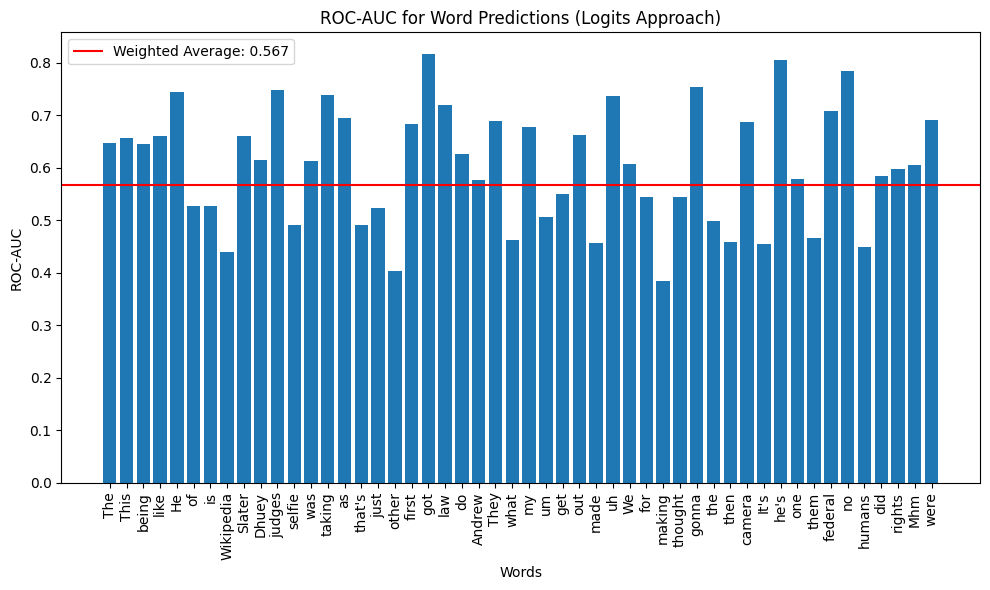

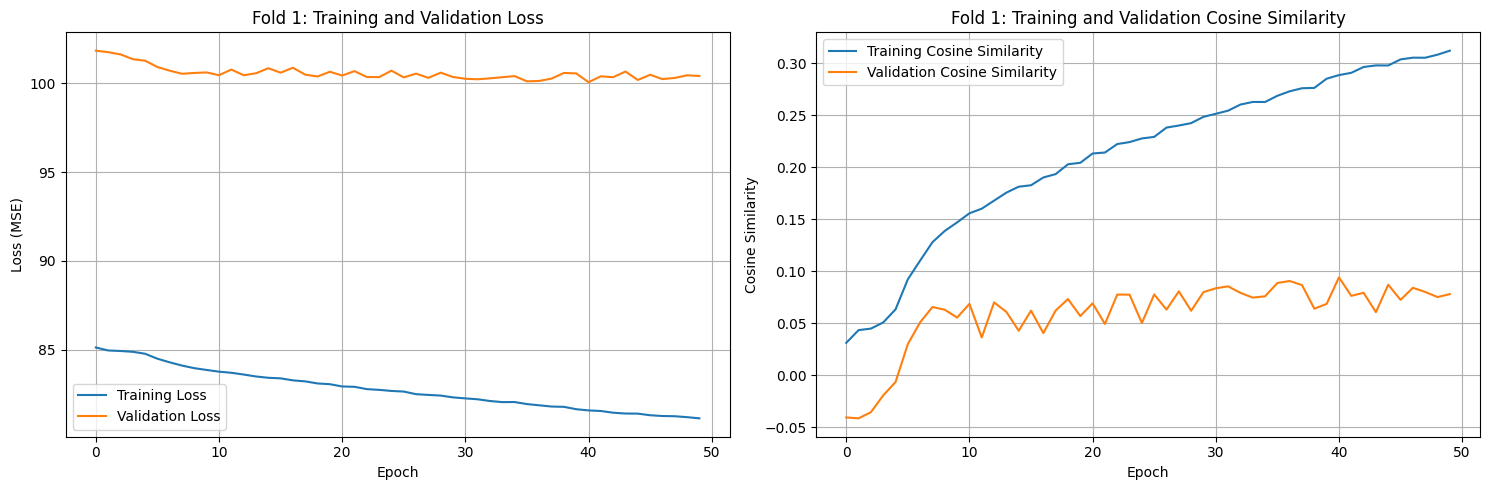


FOLD 2/5


Fold 2, Epoch 1/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 135.98it/s, loss=128, cosine=0.00365]


Epoch 1/50: Train Loss = 88.9478, Train Cosine = 0.0261, Val Loss = 84.1399, Val Cosine = -0.0145
Saved best model checkpoint for fold 2 (Val Cosine: -0.0145).


Fold 2, Epoch 2/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 133.41it/s, loss=75.3, cosine=-0.0456]


Epoch 2/50: Train Loss = 88.8255, Train Cosine = 0.0351, Val Loss = 84.0982, Val Cosine = -0.0155


Fold 2, Epoch 3/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 132.45it/s, loss=107, cosine=0.0478]


Epoch 3/50: Train Loss = 88.7863, Train Cosine = 0.0387, Val Loss = 84.0134, Val Cosine = -0.0087
Saved best model checkpoint for fold 2 (Val Cosine: -0.0087).


Fold 2, Epoch 4/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 131.64it/s, loss=82, cosine=0.0625]


Epoch 4/50: Train Loss = 88.7152, Train Cosine = 0.0469, Val Loss = 84.0381, Val Cosine = -0.0136


Fold 2, Epoch 5/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 131.57it/s, loss=81.5, cosine=0.0614]


Epoch 5/50: Train Loss = 88.4533, Train Cosine = 0.0778, Val Loss = 83.9898, Val Cosine = 0.0001
Saved best model checkpoint for fold 2 (Val Cosine: 0.0001).


Fold 2, Epoch 6/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 128.15it/s, loss=87.1, cosine=0.0941]


Epoch 6/50: Train Loss = 88.2354, Train Cosine = 0.0968, Val Loss = 83.8349, Val Cosine = 0.0232
Saved best model checkpoint for fold 2 (Val Cosine: 0.0232).


Fold 2, Epoch 7/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 123.01it/s, loss=85.7, cosine=0.163]


Epoch 7/50: Train Loss = 88.0455, Train Cosine = 0.1114, Val Loss = 83.4805, Val Cosine = 0.0516
Saved best model checkpoint for fold 2 (Val Cosine: 0.0516).


Fold 2, Epoch 8/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 128.20it/s, loss=94.2, cosine=0.119]


Epoch 8/50: Train Loss = 87.9205, Train Cosine = 0.1184, Val Loss = 83.4156, Val Cosine = 0.0586
Saved best model checkpoint for fold 2 (Val Cosine: 0.0586).


Fold 2, Epoch 9/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 127.89it/s, loss=79.9, cosine=0.184]


Epoch 9/50: Train Loss = 87.7776, Train Cosine = 0.1315, Val Loss = 83.3198, Val Cosine = 0.0688
Saved best model checkpoint for fold 2 (Val Cosine: 0.0688).


Fold 2, Epoch 10/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 126.47it/s, loss=97.4, cosine=0.0947]


Epoch 10/50: Train Loss = 87.6880, Train Cosine = 0.1407, Val Loss = 83.5322, Val Cosine = 0.0507


Fold 2, Epoch 11/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 124.79it/s, loss=79.7, cosine=0.167]


Epoch 11/50: Train Loss = 87.5984, Train Cosine = 0.1471, Val Loss = 83.3814, Val Cosine = 0.0645


Fold 2, Epoch 12/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 128.42it/s, loss=102, cosine=0.155]


Epoch 12/50: Train Loss = 87.5506, Train Cosine = 0.1514, Val Loss = 83.0610, Val Cosine = 0.0876
Saved best model checkpoint for fold 2 (Val Cosine: 0.0876).


Fold 2, Epoch 13/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 128.02it/s, loss=94.6, cosine=0.178]


Epoch 13/50: Train Loss = 87.4384, Train Cosine = 0.1594, Val Loss = 83.1399, Val Cosine = 0.0847


Fold 2, Epoch 14/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 127.59it/s, loss=96.6, cosine=0.178]


Epoch 14/50: Train Loss = 87.3556, Train Cosine = 0.1661, Val Loss = 83.1401, Val Cosine = 0.0816


Fold 2, Epoch 15/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 123.24it/s, loss=128, cosine=0.154]


Epoch 15/50: Train Loss = 87.2688, Train Cosine = 0.1724, Val Loss = 82.9960, Val Cosine = 0.0923
Saved best model checkpoint for fold 2 (Val Cosine: 0.0923).


Fold 2, Epoch 16/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 126.74it/s, loss=94.6, cosine=0.227]


Epoch 16/50: Train Loss = 87.1719, Train Cosine = 0.1790, Val Loss = 83.1384, Val Cosine = 0.0812


Fold 2, Epoch 17/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 127.40it/s, loss=77.6, cosine=0.183]


Epoch 17/50: Train Loss = 87.1221, Train Cosine = 0.1819, Val Loss = 83.0374, Val Cosine = 0.0917


Fold 2, Epoch 18/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 125.14it/s, loss=77.5, cosine=0.11]


Epoch 18/50: Train Loss = 87.0867, Train Cosine = 0.1841, Val Loss = 83.0312, Val Cosine = 0.0864


Fold 2, Epoch 19/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 123.13it/s, loss=87.5, cosine=0.21]


Epoch 19/50: Train Loss = 87.0382, Train Cosine = 0.1867, Val Loss = 83.4930, Val Cosine = 0.0490


Fold 2, Epoch 20/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 126.89it/s, loss=82.1, cosine=0.23]


Epoch 20/50: Train Loss = 86.9712, Train Cosine = 0.1909, Val Loss = 82.9994, Val Cosine = 0.0951
Saved best model checkpoint for fold 2 (Val Cosine: 0.0951).


Fold 2, Epoch 21/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 126.20it/s, loss=84.6, cosine=0.223]


Epoch 21/50: Train Loss = 86.8325, Train Cosine = 0.1997, Val Loss = 82.8798, Val Cosine = 0.1041
Saved best model checkpoint for fold 2 (Val Cosine: 0.1041).


Fold 2, Epoch 22/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 125.96it/s, loss=92.2, cosine=0.181]


Epoch 22/50: Train Loss = 86.7593, Train Cosine = 0.2053, Val Loss = 83.1313, Val Cosine = 0.0816


Fold 2, Epoch 23/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 127.30it/s, loss=68.8, cosine=0.252]


Epoch 23/50: Train Loss = 86.7247, Train Cosine = 0.2059, Val Loss = 82.8614, Val Cosine = 0.1040


Fold 2, Epoch 24/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 123.18it/s, loss=98.1, cosine=0.163]


Epoch 24/50: Train Loss = 86.6421, Train Cosine = 0.2120, Val Loss = 83.1553, Val Cosine = 0.0810


Fold 2, Epoch 25/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 125.18it/s, loss=79.8, cosine=0.146]


Epoch 25/50: Train Loss = 86.5965, Train Cosine = 0.2139, Val Loss = 82.8907, Val Cosine = 0.0963


Fold 2, Epoch 26/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 125.74it/s, loss=86, cosine=0.196]


Epoch 26/50: Train Loss = 86.5394, Train Cosine = 0.2167, Val Loss = 83.2373, Val Cosine = 0.0768


Fold 2, Epoch 27/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 112.21it/s, loss=94, cosine=0.232]


Epoch 27/50: Train Loss = 86.4484, Train Cosine = 0.2226, Val Loss = 83.0672, Val Cosine = 0.0881


Fold 2, Epoch 28/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 121.92it/s, loss=89.3, cosine=0.254]


Epoch 28/50: Train Loss = 86.3776, Train Cosine = 0.2261, Val Loss = 83.0710, Val Cosine = 0.0904


Fold 2, Epoch 29/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 125.04it/s, loss=74, cosine=0.186]


Epoch 29/50: Train Loss = 86.3329, Train Cosine = 0.2279, Val Loss = 82.9566, Val Cosine = 0.0954


Fold 2, Epoch 30/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 124.89it/s, loss=85.8, cosine=0.165]


Epoch 30/50: Train Loss = 86.2685, Train Cosine = 0.2316, Val Loss = 83.0672, Val Cosine = 0.0862


Fold 2, Epoch 31/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 123.90it/s, loss=85.8, cosine=0.184]
/var/folders/z7/qrc5k22j2qq05jzdksv8hd_00000gn/T/ipykernel_19736/1535775755.py:356: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_on

Epoch 31/50: Train Loss = 86.2420, Train Cosine = 0.2325, Val Loss = 83.2370, Val Cosine = 0.0752
Early stopping triggered after 31 epochs.
Found 40 words with at least 5 repetitions (14.9% of unique words)


/var/folders/z7/qrc5k22j2qq05jzdksv8hd_00000gn/T/ipykernel_19736/1535775755.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(X[i:i+1], dtype=torch.float32)



Fold 2 Test Results: Loss = 88.3153, Cosine Similarity = 0.0910


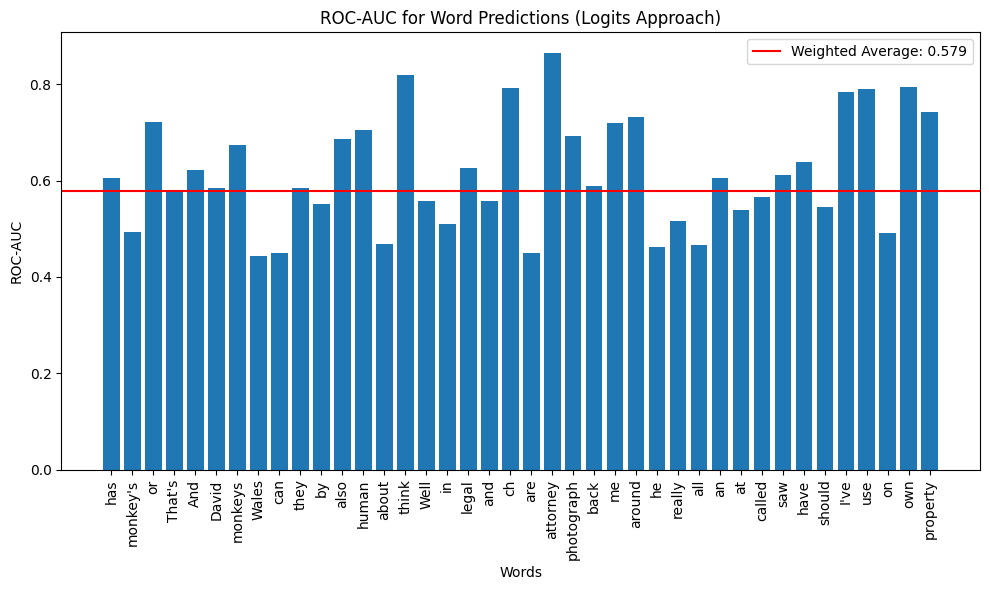

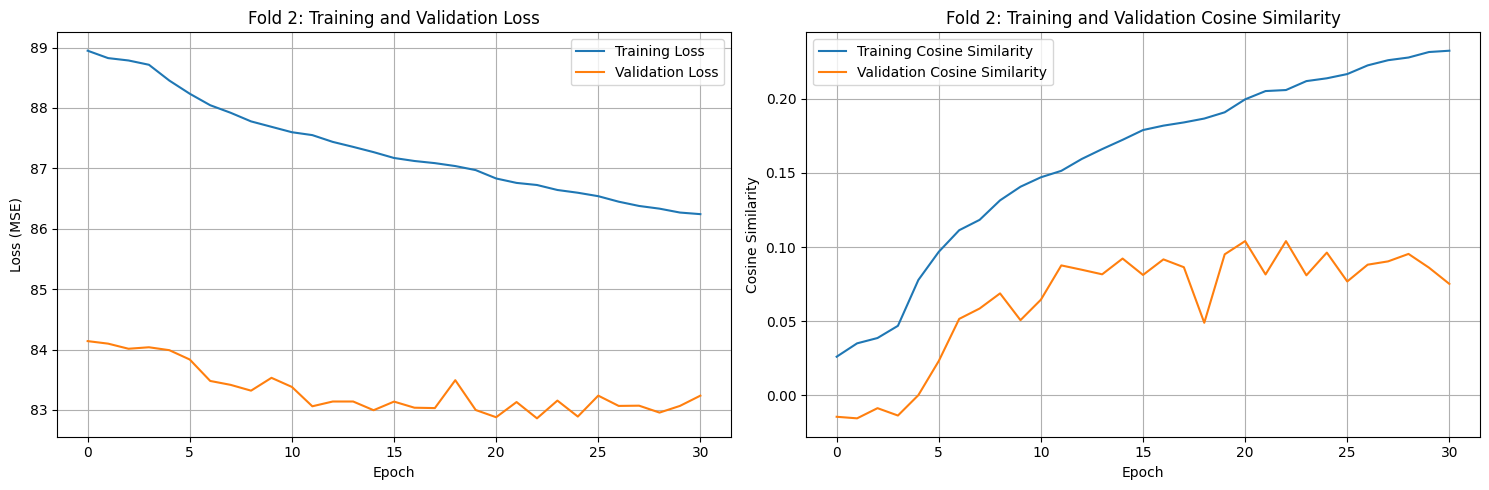


FOLD 3/5


Fold 3, Epoch 1/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 135.06it/s, loss=87.4, cosine=0.0666]


Epoch 1/50: Train Loss = 89.9011, Train Cosine = 0.0329, Val Loss = 86.7438, Val Cosine = -0.0693
Saved best model checkpoint for fold 3 (Val Cosine: -0.0693).


Fold 3, Epoch 2/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 129.71it/s, loss=106, cosine=0.0137]


Epoch 2/50: Train Loss = 89.7741, Train Cosine = 0.0391, Val Loss = 86.6608, Val Cosine = -0.0687
Saved best model checkpoint for fold 3 (Val Cosine: -0.0687).


Fold 3, Epoch 3/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 128.55it/s, loss=95.2, cosine=0.0586]


Epoch 3/50: Train Loss = 89.7482, Train Cosine = 0.0423, Val Loss = 86.6302, Val Cosine = -0.0737


Fold 3, Epoch 4/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 117.05it/s, loss=96.3, cosine=0.0518]


Epoch 4/50: Train Loss = 89.6923, Train Cosine = 0.0482, Val Loss = 86.5818, Val Cosine = -0.0633
Saved best model checkpoint for fold 3 (Val Cosine: -0.0633).


Fold 3, Epoch 5/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 125.39it/s, loss=89.2, cosine=0.0511]


Epoch 5/50: Train Loss = 89.5007, Train Cosine = 0.0685, Val Loss = 86.4918, Val Cosine = -0.0439
Saved best model checkpoint for fold 3 (Val Cosine: -0.0439).


Fold 3, Epoch 6/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 125.13it/s, loss=99.8, cosine=0.105]


Epoch 6/50: Train Loss = 89.2657, Train Cosine = 0.0912, Val Loss = 86.0997, Val Cosine = -0.0022
Saved best model checkpoint for fold 3 (Val Cosine: -0.0022).


Fold 3, Epoch 7/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 116.22it/s, loss=91.1, cosine=0.161]


Epoch 7/50: Train Loss = 89.0817, Train Cosine = 0.1072, Val Loss = 86.0867, Val Cosine = 0.0027
Saved best model checkpoint for fold 3 (Val Cosine: 0.0027).


Fold 3, Epoch 8/50:  26%|████████████████████████████████▌                                                                                            | 24/92 [00:00<00:00, 112.23it/s, loss=92.5, cosine=0.118]

In [ ]:
# Train model across 5 different lags and plot the results.
# For each lag: 
#  build neural data around that lag
#  for each fold:
#    maybe evaluate which electrodes are significant
#    run training (maybe get ensemble model)
#    evaluate model over ROC-AUC
lags = np.arange(-900, 1000, 100)
weighted_roc_means = []
for lag in lags:
    # Maybe make it so only words in all lags are included.
    print('running lag:', lag)
    X, Y, selected_words = get_data(lag)

    X_tensor = torch.FloatTensor(X)
    Y_tensor = torch.FloatTensor(Y)
    
    print(f"X_tensor shape: {X_tensor.shape}, Y_tensor shape: {Y_tensor.shape}")
    
    models, histories, cv_results, roc_results, weighted_roc_mean = train_pitom_model_cv(
        X_tensor, Y_tensor, selected_words,
        model_params={
            'conv_filters': 128,
            'reg': 0.35,
            'reg_head': 0,
            'dropout': 0.2
        },
        training_params={
            'batch_size': 32,
            'epochs': 50,
            'learning_rate': 0.001,
            'weight_decay': 0.0001,
            'early_stopping_patience': 10,
            'n_folds': 5
        }
    )
    weighted_roc_means.append(weighted_roc_mean)

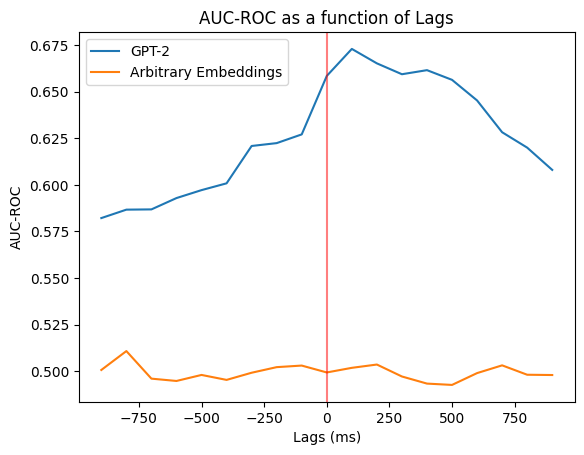

In [171]:
plt.plot(lags, weighted_roc_means, label='GPT-2')
plt.plot(lags, weighted_roc_means_arbitrary, label='Arbitrary Embeddings')
plt.axvline(0, color='red', alpha=0.5)
plt.xlabel('Lags (ms)')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC as a function of Lags')
plt.legend()
plt.show()

In [ ]:
# Train model across 5 different lags and plot the results.
# For each lag: 
#  build neural data around that lag
#  for each fold:
#    maybe evaluate which electrodes are significant
#    run training (maybe get ensemble model)
#    evaluate model over ROC-AUC
lags = np.arange(-900, 1000, 100)
weighted_roc_means_arbitrary = []
for lag in lags:
    # Maybe make it so only words in all lags are included.
    print('running lag:', lag)
    X, Y_old, selected_words = get_data(lag)
    # Replace Y with arbitrary embeddings
    unique_words = list(set(selected_words))
    word_to_idx = {}
    for i, word in enumerate(selected_words):
        if word not in word_to_idx:
            word_to_idx[word] = []
        word_to_idx[word].append(i)
        
    arbitrary_embeddings = np.random.uniform(low=-1.0, high=1.0, size=(len(unique_words), 50))
    Y_arb = np.zeros((Y_old.shape[0], 50))
    for i, word in enumerate(unique_words):
        for idx in word_to_idx[word]:
            Y_arb[idx] = arbitrary_embeddings[i]

    X_tensor = torch.FloatTensor(X)
    Y_tensor = torch.FloatTensor(Y_arb)
    
    print(f"X_tensor shape: {X_tensor.shape}, Y_tensor shape: {Y_tensor.shape}")
    
    models_arb, histories_arb, cv_results_arb, roc_results_arb, weighted_roc_mean_arb = train_pitom_model_cv(
        X_tensor, Y_tensor, selected_words,
        model_params={
            'conv_filters': 128,
            'reg': 0.35,
            'reg_head': 0,
            'dropout': 0.2
        },
        training_params={
            'batch_size': 32,
            'epochs': 50,
            'learning_rate': 0.001,
            'weight_decay': 0.0001,
            'early_stopping_patience': 10,
            'n_folds': 5
        }
    )
    weighted_roc_means_arbitrary.append(weighted_roc_mean_arb)